In [25]:
#Predict the survival time of the patient
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, AalenAdditiveFitter
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import preprocessing
import seaborn as sns


In [26]:
#Read data from radiomics.csv file
rt_data = pd.read_csv("./train/radiomics.csv")
#Read data from clinical_data.csv
ct_data = pd.read_csv("./train/clinical_data.csv")
#Read data from output.csv file
op_data = pd.read_csv("./train/output.csv")
test_ct_data = pd.read_csv("./test/clinical_data.csv")
test_rt_data = pd.read_csv("./test/radiomics.csv")

In [46]:
#Merging data and access features from rt_data and ct_data
final_data = pd.merge(ct_data,rt_data,on = 'PatientID',)
#Merging data and access specific features from final_data and op_data
final_data = pd.merge(final_data,op_data[['PatientID', 'SurvivalTime', 'Event']],on = 'PatientID')
#check first five lines of final_data
final_data.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,...,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,SurvivalTime,Event
0,202,Adenocarcinoma,0,0,l2,2,66.0000,0.027815,0.274892,48.559242,...,14592.303730,0.891330,0.003562,954.749136,0.003384,851.987373,0.004444,1651.710761,1378,0
1,371,large cell,0,2,l1,4,64.5722,0.023015,0.188210,75.703368,...,22881.932690,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589,379,1
2,246,squamous cell carcinoma,0,3,l1,2,66.0452,0.027348,0.265740,70.434367,...,18773.106000,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080,573,1
3,240,nos,0,2,l1,3,59.3566,0.026811,0.255406,46.818800,...,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046,959,0
4,284,squamous cell carcinoma,0,3,l1,4,71.0554,0.023691,0.199424,53.795911,...,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812,2119,0


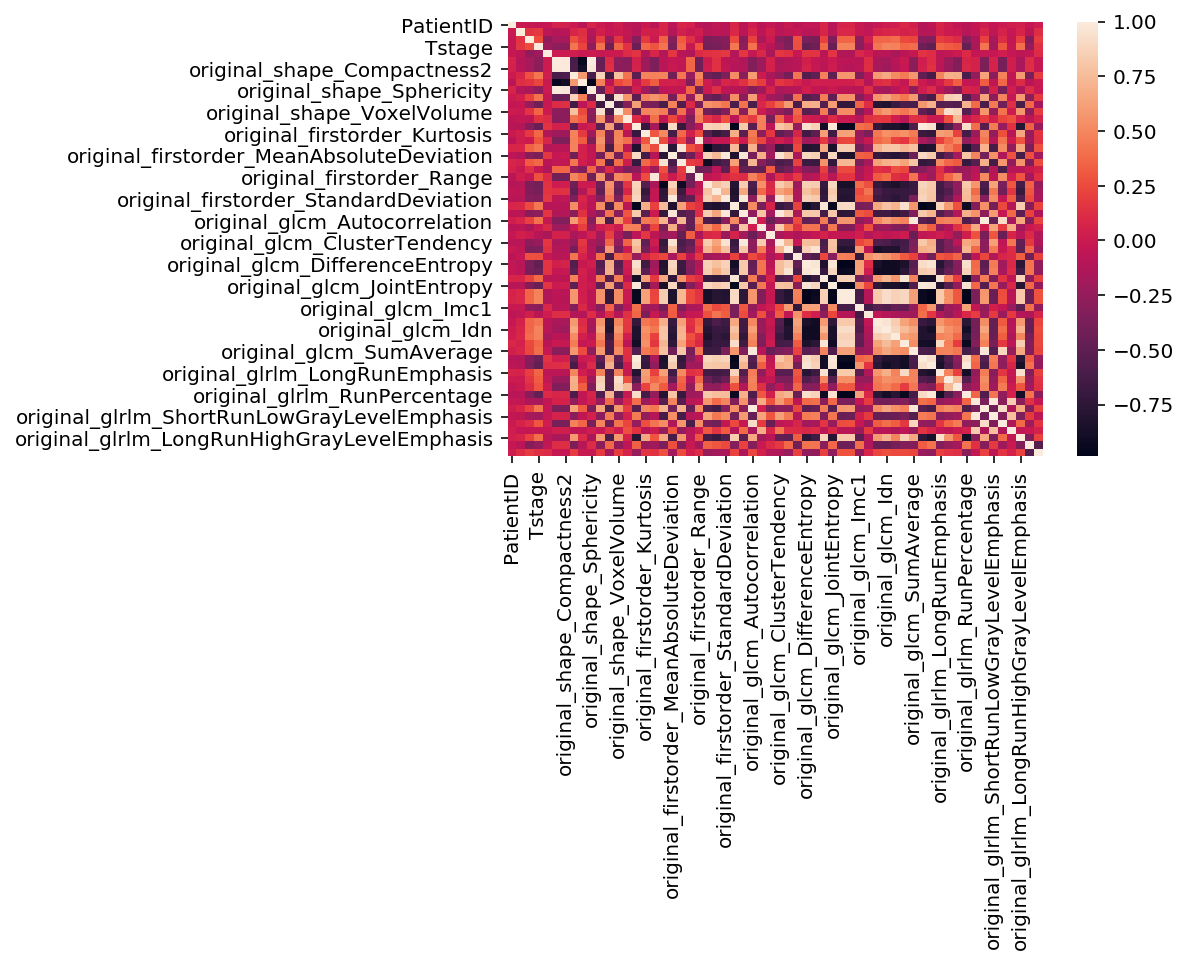

In [47]:
#check correlation between features
feature_correlation = final_data.corr()
#correlation using heat map 
sns.heatmap(feature_correlation)

In [53]:
#correlation using matrix
feature_correlation
#if we want to check correlation for specific columns we can use below code
#Correlation with output variable
cor_target = abs(feature_correlation["original_glrlm_LongRunEmphasis"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

original_shape_SurfaceVolumeRatio              0.551579
original_firstorder_Entropy                    0.801817
original_firstorder_Kurtosis                   0.604427
original_firstorder_Mean                       0.614075
original_firstorder_MeanAbsoluteDeviation      0.651617
original_firstorder_Median                     0.511717
original_firstorder_RootMeanSquared            0.631004
original_firstorder_Skewness                   0.653917
original_firstorder_StandardDeviation          0.625636
original_firstorder_Uniformity                 0.874323
original_firstorder_Variance                   0.557367
original_glcm_ClusterTendency                  0.528780
original_glcm_Contrast                         0.526328
original_glcm_DifferenceEntropy                0.771970
original_glcm_DifferenceAverage                0.663382
original_glcm_JointEnergy                      0.948088
original_glcm_JointEntropy                     0.807138
original_glcm_Id                               0

In [49]:
selected_features = ['PatientID','original_shape_Maximum3DDiameter','original_shape_Sphericity','original_shape_SurfaceVolumeRatio',
                    'original_glcm_JointEntropy','original_glcm_Idmn','original_glcm_Imc2',
                     'SurvivalTime', 'Event', 'Nstage', 'SourceDataset', 'age']
X_train = pd.DataFrame(final_data[selected_features])
X_train.shape

(300, 12)

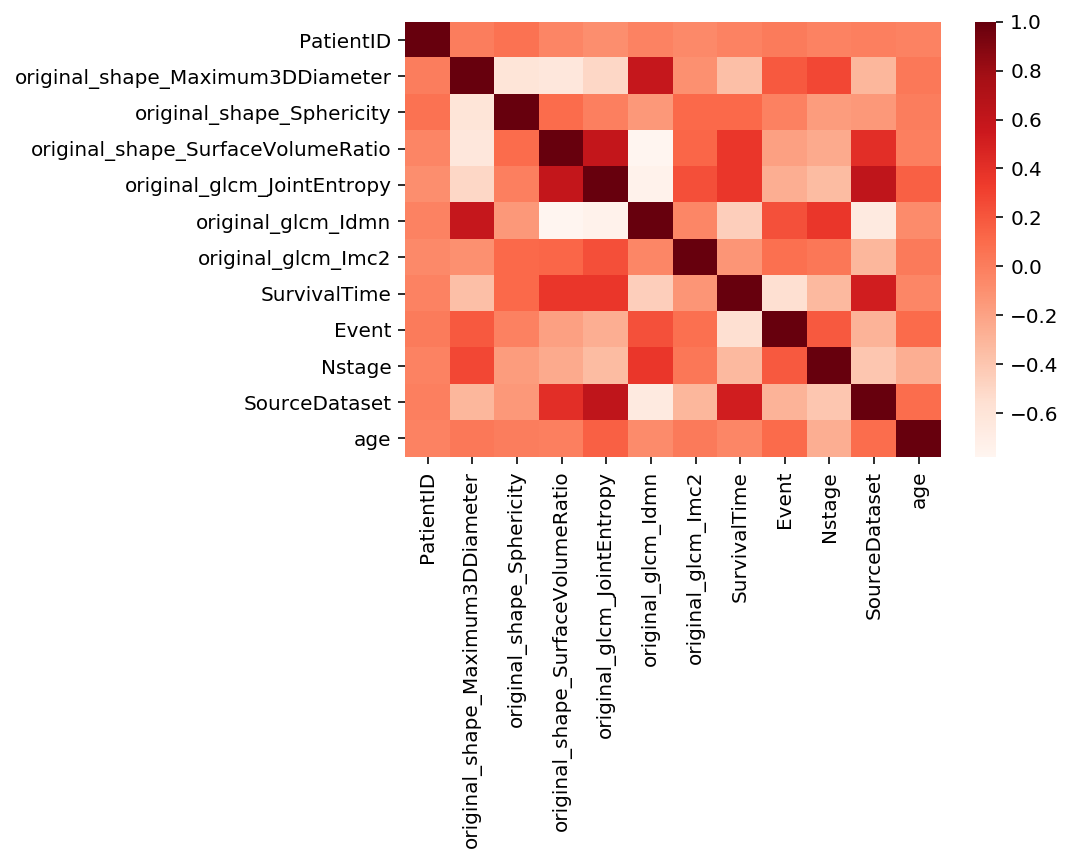

In [54]:
#Provides correlation of every single feature of final_data
selected_features_correlation = X_train.corr()
sns.heatmap(selected_features_correlation, cmap=plt.cm.Reds)

In [50]:
X_train.isna().sum()

PatientID                             0
original_shape_Maximum3DDiameter      0
original_shape_Sphericity             0
original_shape_SurfaceVolumeRatio     0
original_glcm_JointEntropy            0
original_glcm_Idmn                    0
original_glcm_Imc2                    0
SurvivalTime                          0
Event                                 0
Nstage                                0
SourceDataset                         0
age                                  16
dtype: int64

In [51]:
#Fill the missing values 
mean_age_value = ct_data.age.mean()
X_train['age'] = X_train['age'].fillna(value = mean_age_value)
X_train.head()

,PatientID,original_shape_Maximum3DDiameter,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_glcm_JointEntropy,original_glcm_Idmn,original_glcm_Imc2,SurvivalTime,Event,Nstage,SourceDataset,age
0,202,48.559242,0.650210,0.275228,9.270194,0.981053,0.901525,1378,0,0,l2,66.0000
1,371,75.703368,0.573079,0.240727,7.551168,0.993282,0.932847,379,1,2,l1,64.5722
2,246,70.434367,0.642913,0.200766,5.686554,0.995095,0.884911,573,1,3,l1,66.0452
3,240,46.818800,0.634469,0.323878,7.536161,0.993509,0.902811,959,0,2,l1,59.3566
4,284,53.795911,0.584242,0.327241,6.940307,0.992658,0.911356,2119,0,3,l1,71.0554


In [52]:
#Encoding the categeorical data
lb_encode = LabelEncoder()
X_train['SourceDataset'] = lb_encode.fit_transform(X_train['SourceDataset'])
X_train.head()

,PatientID,original_shape_Maximum3DDiameter,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_glcm_JointEntropy,original_glcm_Idmn,original_glcm_Imc2,SurvivalTime,Event,Nstage,SourceDataset,age
0,202,48.559242,0.650210,0.275228,9.270194,0.981053,0.901525,1378,0,0,1,66.0000
1,371,75.703368,0.573079,0.240727,7.551168,0.993282,0.932847,379,1,2,0,64.5722
2,246,70.434367,0.642913,0.200766,5.686554,0.995095,0.884911,573,1,3,0,66.0452
3,240,46.818800,0.634469,0.323878,7.536161,0.993509,0.902811,959,0,2,0,59.3566
4,284,53.795911,0.584242,0.327241,6.940307,0.992658,0.911356,2119,0,3,0,71.0554


In [57]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(X_train, 'SurvivalTime', event_col='Event')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

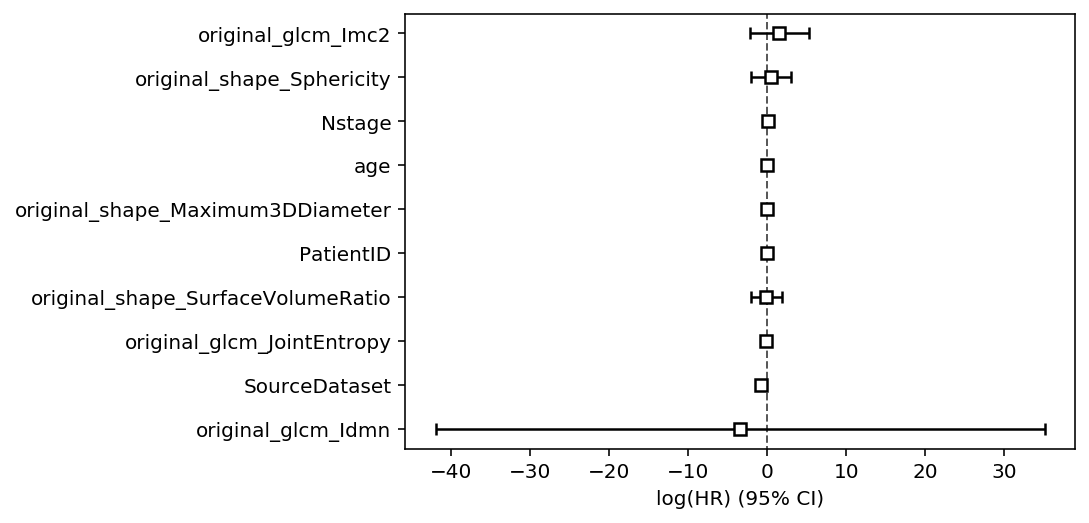

In [58]:
#Provides info on how our duration is affected by each feauture
cph.plot()

In [61]:
#Merging data and access specific features from rt_data and ct_data
x_test = pd.merge(test_ct_data[['PatientID','Nstage','SourceDataset', 'age']],
                     test_rt_data[['PatientID','original_shape_Maximum3DDiameter',
                              'original_shape_Sphericity',
                              'original_shape_SurfaceVolumeRatio',
                              'original_glcm_JointEntropy',
                              'original_glcm_Idmn',
                              'original_glcm_Imc2',
                             ]],
                     on = 'PatientID')

x_test.head()

,PatientID,Nstage,SourceDataset,age,original_shape_Maximum3DDiameter,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_glcm_JointEntropy,original_glcm_Idmn,original_glcm_Imc2
0,13,0,l1,44.3970,106.901824,0.666783,0.114528,5.048950,0.999197,0.906520
1,155,3,l1,63.3183,18.814888,0.713126,0.703879,9.139372,0.974940,0.957683
2,404,2,l1,64.7255,105.080921,0.449704,0.315298,5.533082,0.996769,0.873649
3,407,0,l1,65.3635,46.968074,0.704309,0.282104,6.253236,0.996313,0.890556
4,9,0,l2,50.0000,56.542020,0.483115,0.376032,9.813896,0.978024,0.750815


In [62]:
x_test.isna().sum()

PatientID                            0
Nstage                               0
SourceDataset                        0
age                                  4
original_shape_Maximum3DDiameter     0
original_shape_Sphericity            0
original_shape_SurfaceVolumeRatio    0
original_glcm_JointEntropy           0
original_glcm_Idmn                   0
original_glcm_Imc2                   0
dtype: int64

In [63]:
#Fill missing values for test data
mean_age_value = ct_data.age.mean()
x_test['age'] = x_test['age'].fillna(value = mean_age_value)

In [85]:
#Encoding the categeorical data
lb_encode = LabelEncoder()
x_test['SourceDataset'] = lb_encode.fit_transform(x_test['SourceDataset'])
x_test.head()

,PatientID,Nstage,SourceDataset,age,original_shape_Maximum3DDiameter,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_glcm_JointEntropy,original_glcm_Idmn,original_glcm_Imc2
0,13,0,0,44.3970,106.901824,0.666783,0.114528,5.048950,0.999197,0.906520
1,155,3,0,63.3183,18.814888,0.713126,0.703879,9.139372,0.974940,0.957683
2,404,2,0,64.7255,105.080921,0.449704,0.315298,5.533082,0.996769,0.873649
3,407,0,0,65.3635,46.968074,0.704309,0.282104,6.253236,0.996313,0.890556
4,9,0,1,50.0000,56.542020,0.483115,0.376032,9.813896,0.978024,0.750815


In [119]:
y_train = pd.DataFrame(x_test['PatientID'])
prediction_result = cph.predict_expectation(x_test)
prediction_result.columns = ['SurvivalTime']
z_train = pd.concat([y_train, prediction_result], sort=False, axis=1)
z_train['Event'] = 'NAN'
export_csv = z_train.to_csv(r'./predictions.csv', index = None, header=True) 

In [66]:
cph.print_summary()

In [70]:
#Using threshold 0.05 our data is satisfying all propotional hazard assumptions
cph.check_assumptions(X_train, p_value_threshold = 0.05, show_plots = True)

Proportional hazard assumption looks okay.


The ``p_value_threshold`` is set at 0.5. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'PatientID' failed the non-proportional test: p-value is 0.3521.

   Advice 1: the functional form of the variable 'PatientID' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'PatientID' using pd.cut, and then specify it in
`strata=['PatientID', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'original_glcm_JointEntropy' failed the non-proportional test: p-value is 0.4905.

   Advice 1: the functional form of the variable 'original_glcm_JointEntropy' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link 

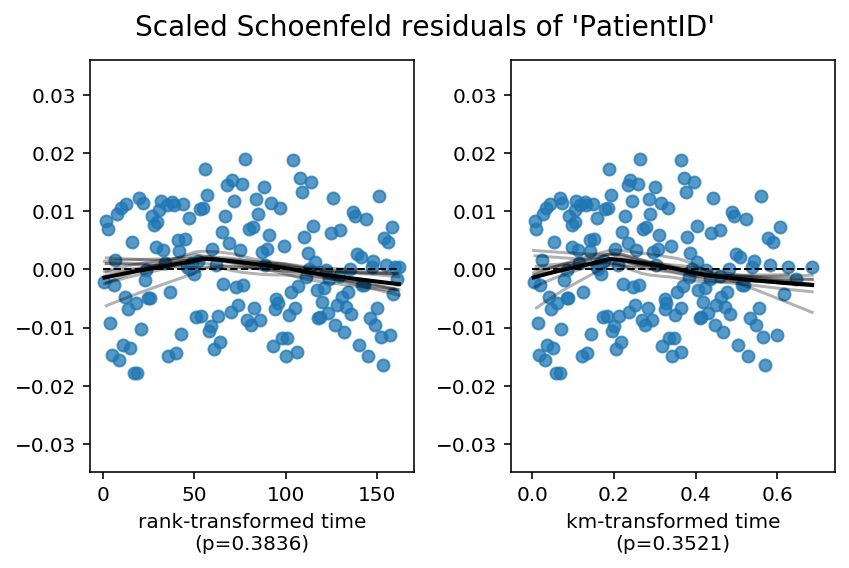

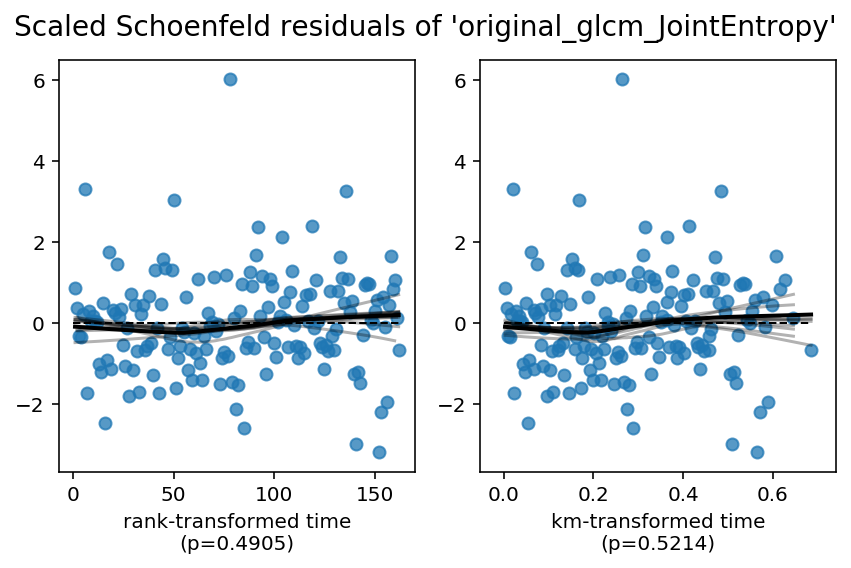

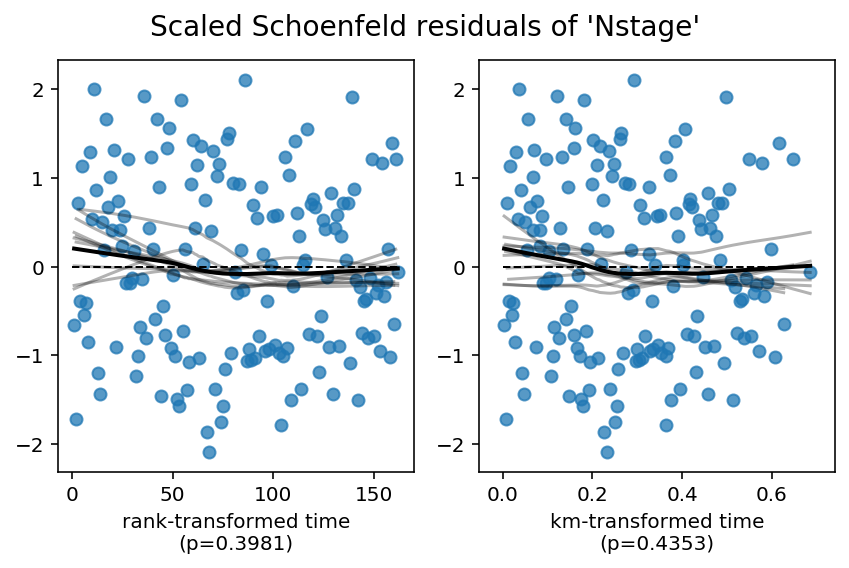

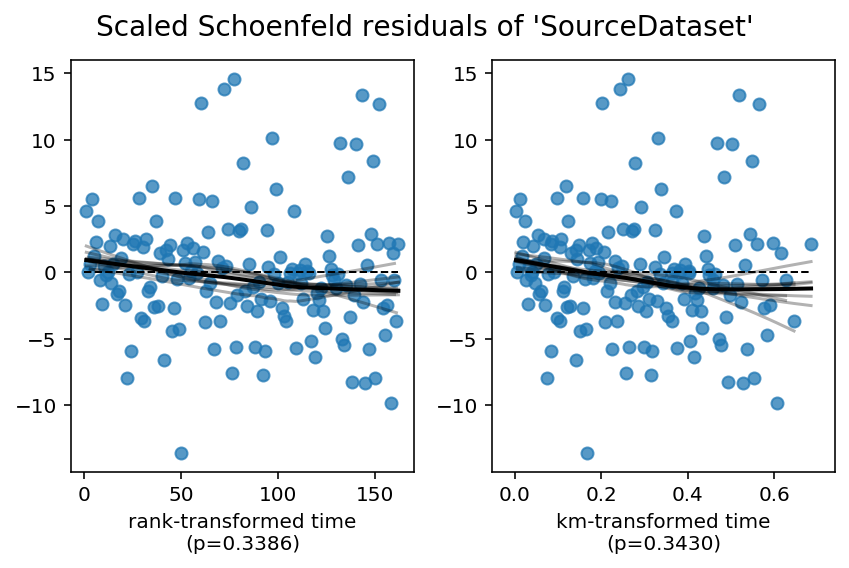

In [72]:
#chaing threshold to 0.5 dosen't satisfy propotional hazard assumptions
cph.check_assumptions(X_train, p_value_threshold = 0.5, show_plots = True)#check the change in threshold 

In [67]:
#Using AalenAdditiveFitter for above data
aaf = AalenAdditiveFitter()
aaf.fit(X_train, 'SurvivalTime', 'Event')
aaf.predict_median(X_train)
aaf.print_summary()